In [268]:
import numpy as np
import pandas as pd
import os
import json
import warnings
import time
from datetime import datetime
from dataclasses import dataclass
from typing import Optional, List, Dict, Any

# Optuna for optimization
import optuna
from optuna.samplers import TPESampler

# MLForecast
from mlforecast import MLForecast
from mlforecast.auto import AutoMLForecast, AutoModel
from mlforecast.lag_transforms import (
    RollingMean, 
    RollingStd, 
    ExpandingMean,
    ExponentiallyWeightedMean,
)

# Models
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

# Evaluation
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import mae, mse, rmse

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore', message='.*sklearn.utils.parallel.delayed.*')
warnings.filterwarnings("ignore")
optuna.logging.set_verbosity(optuna.logging.WARNING)

## General config

In [393]:
user = "Lilian"  # Your username for paths

# Paths
DATA_PATH = rf"C:\Users\{user}\OneDrive - purdue.edu\VS code\Data\ATC\merged_data\Prebuilt_panels\P1_ML.csv"
OUTPUT_PATH = rf"C:\Users\{user}\OneDrive - purdue.edu\VS code\Data\ATC\Forecast\ML\\"

# Target selection
TARGET = 'y_1'  # 'y' = Units Reimbursed, 'y_1' = Number of Prescriptions
TARGET_NAME = 'Units Reimbursed' if TARGET == 'y' else 'Number of Prescriptions'

# State filtering (None = all states)
STATES = ['MI']  # Options: None, ['IN'], ['IN', 'OH', 'IL', 'MI'], etc.

# Optimization settings
NUM_SAMPLES = 50  # Optuna trials per model (increase to 50-100 for production)

In [394]:
@dataclass
class MLForecastConfig:
    
    # Target
    target_col: str = TARGET
    target_name: str = TARGET_NAME
    
    # Forecast parameters
    horizon: int = 8  # Quarters to forecast
    season_length: int = 4
    freq: str = 'QS'
    
    # Cross-validation
    n_windows: int = 2 # Look carefully at this since we have few observations. The reasonable maximum is 3 (if it runs ofc)
    step_size: int = 4  
    
    train_start: str = '2017-01-01'
    train_end: str = '2024-10-01'
    
    n_jobs: int = -1
    random_state: int = 42

config = MLForecastConfig()

## Section 1: Load Pre-Built Panel and Validate it

In [395]:
# Load pre-built panel
df = pd.read_csv(DATA_PATH)
df['ds'] = pd.to_datetime(df['ds'])

print(f"\nPanel Loaded: P1_ML.csv")
print(f"   • Shape: {df.shape}")
print(f"   • Columns: {df.columns.tolist()}")

df.head()


Panel Loaded: P1_ML.csv
   • Shape: (133414, 7)
   • Columns: ['unique_id', 'ds', 'y', 'y_1', 'population', 'population_low', 'population_high']


,unique_id,ds,y,y_1,population,population_low,population_high
0,AK_A01,2017-01-01,36119.500,1235.0,180677.666667,NaN,NaN
1,AK_A01,2017-04-01,70157.400,2369.0,184889.333333,NaN,NaN
2,AK_A01,2017-07-01,58421.290,1624.0,184185.666667,NaN,NaN
3,AK_A01,2017-10-01,65281.208,2537.0,193784.666667,NaN,NaN
4,AK_A01,2018-01-01,50398.410,1365.0,196836.333333,NaN,NaN


In [396]:
# Filter states if specified
if STATES is not None:
    df['state'] = df['unique_id'].str.split('_').str[0]
    df = df[df['state'].isin(STATES)].copy()
    df = df.drop(columns=['state'])
    print(f"\nFiltered to states: {STATES}")
    print(f"   • Remaining series: {df['unique_id'].nunique()}")
    print(f"   • Remaining rows: {len(df):,}")
else:
    print(f"\nUsing all states")
    print(f"   • Total series: {df['unique_id'].nunique()}")


Filtered to states: ['MI']
   • Remaining series: 84
   • Remaining rows: 3,335


In [397]:
# Panel validation

print("\nPanel Validation:")
print("-" * 40)

required = ['unique_id', 'ds', 'y', 'population']
missing = [c for c in required if c not in df.columns]
print(f"Required columns: {'PASS' if not missing else f'FAIL - Missing: {missing}'}")

n_dups = df.groupby(['unique_id', 'ds']).size().gt(1).sum()
print(f"Duplicate check: {'PASS' if n_dups == 0 else f'FAIL - {n_dups} duplicates'}")

print(f"Missing 'y': {df['y'].isna().sum()}")
print(f"Missing 'population': {df['population'].isna().sum()}")


Panel Validation:
----------------------------------------
Required columns: PASS
Duplicate check: PASS
Missing 'y': 672
Missing 'population': 0


In [398]:
# Checking df for training

HISTORICAL_CUTOFF = pd.to_datetime(config.train_end)

df_historical = df[df['ds'] <= HISTORICAL_CUTOFF].copy()
df_future = df[df['ds'] > HISTORICAL_CUTOFF].copy()

print(f"\nData Split:")
print(f"  Historical: {len(df_historical):,} rows (up to {HISTORICAL_CUTOFF.strftime('%Y-%m-%d')})")
print(f"  Future: {len(df_future):,} rows")


Data Split:
  Historical: 2,663 rows (up to 2024-10-01)
  Future: 672 rows


In [399]:
#Dropping uncomplete series
print("\nBalancing Panel:")
print("-" * 40)

all_dates = sorted(df_historical['ds'].unique())
n_dates = len(all_dates)

series_lengths = df_historical.groupby('unique_id').size()
complete_series = series_lengths[series_lengths == n_dates].index

print(f"Total dates: {n_dates}")
print(f"Complete series: {len(complete_series)}")
print(f"Incomplete series: {len(series_lengths) - len(complete_series)} (removed)")

df_historical = df_historical[df_historical['unique_id'].isin(complete_series)].copy()
df_future = df_future[df_future['unique_id'].isin(complete_series)].copy()


Balancing Panel:
----------------------------------------
Total dates: 32
Complete series: 78
Incomplete series: 6 (removed)


In [400]:
# Create training dataframe
train_df = df_historical[['unique_id', 'ds', TARGET, 'population']].copy()
train_df.columns = ['unique_id', 'ds', 'y', 'population']
train_df = train_df.sort_values(['unique_id', 'ds']).reset_index(drop=True)

print(f"\nTraining DataFrame:")
print(f"  Shape: {train_df.shape}")
print(f"  Series: {train_df['unique_id'].nunique()}")
print(f"  Date range: {train_df['ds'].min().strftime('%Y-%m-%d')} to {train_df['ds'].max().strftime('%Y-%m-%d')}")

train_df.head()


Training DataFrame:
  Shape: (2496, 4)
  Series: 78
  Date range: 2017-01-01 to 2024-10-01


,unique_id,ds,y,population
0,MI_A01,2017-01-01,29756.0,2.393812e+06
1,MI_A01,2017-04-01,45240.0,2.107279e+06
2,MI_A01,2017-07-01,43690.0,1.612241e+06
3,MI_A01,2017-10-01,33071.0,2.432629e+06
4,MI_A01,2018-01-01,31249.0,2.447338e+06


In [401]:
# Create future exogenous dataframes
print("\nFuture Exogenous:")

if len(df_future) > 0 and df_future['population'].notna().any():
    X_future_point = df_future[['unique_id', 'ds', 'population']].copy()
    X_future_point = X_future_point.sort_values(['unique_id', 'ds']).reset_index(drop=True)
    print(f"  X_future_point: {X_future_point.shape}")
else:
    # Create from last known values
    print("  Creating from last known values...")
    last_date = train_df['ds'].max()
    future_dates = pd.date_range(start=last_date + pd.DateOffset(months=3), 
                                  periods=config.horizon, freq=config.freq)
    future_rows = []
    for uid in train_df['unique_id'].unique():
        last_pop = train_df[train_df['unique_id'] == uid]['population'].iloc[-1]
        for date in future_dates:
            future_rows.append({'unique_id': uid, 'ds': date, 'population': last_pop})
    X_future_point = pd.DataFrame(future_rows)
    print(f"  X_future_point: {X_future_point.shape}")

# Low/High scenarios
X_future_low = None
X_future_high = None

if 'population_low' in df_future.columns and df_future['population_low'].notna().any():
    X_future_low = df_future[['unique_id', 'ds', 'population_low']].copy()
    X_future_low.columns = ['unique_id', 'ds', 'population']
    X_future_low = X_future_low.sort_values(['unique_id', 'ds']).reset_index(drop=True)
    print(f"  X_future_low: {X_future_low.shape}")

if 'population_high' in df_future.columns and df_future['population_high'].notna().any():
    X_future_high = df_future[['unique_id', 'ds', 'population_high']].copy()
    X_future_high.columns = ['unique_id', 'ds', 'population']
    X_future_high = X_future_high.sort_values(['unique_id', 'ds']).reset_index(drop=True)
    print(f"  X_future_high: {X_future_high.shape}")


Future Exogenous:
  X_future_point: (624, 3)
  X_future_low: (624, 3)


  X_future_high: (624, 3)


## Section 2: Search Spaces for AutoMLForecast
#### AutoMLForecast from mlforecast library tunes:
1. Model parameters via `config` function (defined above) 
2. Features (lags,transforms) via `init_config` function

In [402]:
print("=" * 60); print("SECTION 2: DEFINE SEARCH SPACES"); print("=" * 60)

def lgb_config(trial: optuna.Trial) -> dict:
    """LightGBM hyperparameter search space."""
    return {
        'n_estimators': trial.suggest_int('n_estimators', 50, 400),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 8, 128, log=True),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'verbosity': -1,
        'random_state': config.random_state,
        'n_jobs': config.n_jobs,
    }

def xgb_config(trial: optuna.Trial) -> dict:
    """XGBoost hyperparameter search space."""
    return {
        'n_estimators': trial.suggest_int('n_estimators', 50, 400),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 10, 100),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'verbosity': 0,
        'random_state': config.random_state,
        'n_jobs': config.n_jobs,
    }

def rf_config(trial: optuna.Trial) -> dict:
    """RandomForest hyperparameter search space."""
    return {
        'n_estimators': trial.suggest_int('n_estimators', 50, 400),
        'max_depth': trial.suggest_int('max_depth', 4, 15),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 5, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'max_features': trial.suggest_float('max_features', 0.3, 1.0),
        'random_state': config.random_state,
        'n_jobs': config.n_jobs,
    }

def ridge_config(trial: optuna.Trial) -> dict:
    """Ridge hyperparameter search space."""
    return {
        'alpha': trial.suggest_float('alpha', 1e-3, 100.0, log=True),
        'random_state': config.random_state,
    }

print("\nModel search spaces defined:")
print("  - LightGBM: n_estimators, max_depth, learning_rate, reg_alpha, reg_lambda, ...")
print("  - XGBoost: n_estimators, max_depth, learning_rate, reg_alpha, reg_lambda, gamma, ...")
print("  - RandomForest: n_estimators, max_depth, min_samples_leaf, ...")
print("  - Ridge: alpha")

SECTION 2: DEFINE SEARCH SPACES

Model search spaces defined:
  - LightGBM: n_estimators, max_depth, learning_rate, reg_alpha, reg_lambda, ...
  - XGBoost: n_estimators, max_depth, learning_rate, reg_alpha, reg_lambda, gamma, ...
  - RandomForest: n_estimators, max_depth, min_samples_leaf, ...
  - Ridge: alpha


In [403]:

def my_init_config(trial: optuna.Trial) -> dict:
    """
    Tune MLForecast features: lags and lag_transforms.
    This is called during optimization to find the best feature configuration.
    """
    # Tune lags
    use_lag_3 = trial.suggest_categorical('use_lag_3', [True, False])
    use_lag_8 = trial.suggest_categorical('use_lag_8', [True, False])
    
    lags = [1, 2, 4]  # Base lags
    #if use_lag_3:
        #lags.append(3)
    #if use_lag_8:
        #lags.append(8)
    #lags = sorted(lags)
    
    # Tune rolling window
    rolling_window = trial.suggest_categorical('rolling_window', [2, 4])
    
    # Tune expanding mean
    use_expanding = trial.suggest_categorical('use_expanding', [True, False])
    
    # Tune EWM
    use_ewm = trial.suggest_categorical('use_ewm', [True, False])
    ewm_alpha = trial.suggest_float('ewm_alpha', 0.1, 0.9) if use_ewm else 0.3
    
    # Build lag_transforms
    lag_transforms = {
        1: [RollingMean(window_size=rolling_window), RollingStd(window_size=rolling_window)],
    }
    
    if use_ewm:
        lag_transforms[1].append(ExponentiallyWeightedMean(alpha=ewm_alpha))
    
    if use_expanding:
        lag_transforms[4] = [ExpandingMean()]
    
    return {
        'lags': lags,
        'lag_transforms': lag_transforms,
        'date_features': ['quarter'],
    }

#This config is neccesary to avoid the error of missing fit parameters in static_features[] when running auto_mlf.fit()
def my_fit_config(trial: optuna.Trial) -> dict:
    """
    Parameters passed to MLForecast.fit()
    """
    return {
        'static_features': [],  # or ['unique_id'] or your static feature columns
        #'dropna': True  # Drop rows with NaNs after feature engineering
    }

print("\nFeature search space (init_config):")
print("  - Lags: [1,2,4] + optional [3,8]")
print("  - Rolling window: 2 or 4")
print("  - Expanding mean: True/False")
print("  - EWM: True/False with tunable alpha")


Feature search space (init_config):
  - Lags: [1,2,4] + optional [3,8]
  - Rolling window: 2 or 4
  - Expanding mean: True/False
  - EWM: True/False with tunable alpha


## Section 3: Run AutoMLForecast Optimization with Optuna

In [380]:
print("=" * 60); print("SECTION 3: AutoMLForecast OPTIMIZATION"); print("=" * 60)

# Create AutoModel instances
auto_lgb = AutoModel(model=lgb.LGBMRegressor(), config=lgb_config)
auto_xgb = AutoModel(model=xgb.XGBRegressor(), config=xgb_config)
auto_rf = AutoModel(model=RandomForestRegressor(), config=rf_config)
auto_ridge = AutoModel(model=Ridge(), config=ridge_config)

# Create AutoMLForecast
auto_mlf = AutoMLForecast(
    models={
        'LightGBM': auto_lgb,
        'XGBoost': auto_xgb,
        'RandomForest': auto_rf,
        'Ridge': auto_ridge,
    },
    freq=config.freq,
    season_length=config.season_length,
    init_config=my_init_config,
    fit_config=my_fit_config,
)

print("\nAutoMLForecast created:")
print(f"  Models: LightGBM, XGBoost, RandomForest, Ridge")
print(f"  Feature tuning: Enabled")

SECTION 3: AutoMLForecast OPTIMIZATION

AutoMLForecast created:
  Models: LightGBM, XGBoost, RandomForest, Ridge
  Feature tuning: Enabled


In [381]:
# Run optimization
print(f"\n{'='*60}")
print("RUNNING OPTIMIZATION")
print(f"{'='*60}")
print(f"  Trials per model: {NUM_SAMPLES}")
print(f"  CV windows: {config.n_windows}")
print(f"  Horizon: {config.horizon} quarters")
print(f"\n  This may take several minutes...\n")

start_time = time.time()

auto_mlf.fit(
    train_df,
    n_windows=config.n_windows,
    h=config.horizon,
    num_samples=NUM_SAMPLES,
)

elapsed = time.time() - start_time
print(f"\nOptimization complete!")
print(f"  Time: {elapsed/60:.1f} minutes")


RUNNING OPTIMIZATION
  Trials per model: 50
  CV windows: 2
  Horizon: 8 quarters

  This may take several minutes...


Optimization complete!
  Time: 2.9 minutes


## Section 4: Analyze Optimization Results

In [382]:
print("=" * 60); print("SECTION 4: OPTIMIZATION RESULTS"); print("=" * 60)

# Summary table
results_summary = []
for model_name, study in auto_mlf.results_.items():
    results_summary.append({
        'Model': model_name,
        'Best_CV_MAE': study.best_value,
        'Num_Trials': len(study.trials),
    })

results_df = pd.DataFrame(results_summary).sort_values('Best_CV_MAE')
best_model_name = results_df.iloc[0]['Model']
best_model_score = results_df.iloc[0]['Best_CV_MAE']

print("\nModel Comparison (sorted by CV MAE):")
print(results_df.to_string(index=False))
print(f"\nBest Model: {best_model_name} (MAE: {best_model_score:,.2f})")

SECTION 4: OPTIMIZATION RESULTS

Model Comparison (sorted by CV MAE):
       Model  Best_CV_MAE  Num_Trials
RandomForest     0.161521          50
     XGBoost     0.169651          50
    LightGBM     0.172517          50
       Ridge     0.225681          50

Best Model: RandomForest (MAE: 0.16)


In [383]:
# Best configurations
print("\n" + "=" * 60); print("BEST CONFIGURATIONS"); print("=" * 60)

best_configs = {}

for model_name, study in auto_mlf.results_.items():
    print(f"\n{model_name}:")
    print("-" * 40)
    
    best_config = study.best_trial.user_attrs['config']
    best_configs[model_name] = best_config
    
    # Key model parameters
    model_params = best_config.get('model_params', {})
    key_params = ['n_estimators', 'max_depth', 'learning_rate', 'reg_alpha', 'reg_lambda', 'alpha']
    print("  Key params:")
    for k in key_params:
        if k in model_params:
            v = model_params[k]
            print(f"    {k}: {v:.4f}" if isinstance(v, float) else f"    {k}: {v}")
    
    # Features
    init_params = best_config.get('mlf_init_params', {})
    print(f"  Lags: {init_params.get('lags', 'default')}")
    print(f"  CV MAE: {study.best_value:,.2f}")


BEST CONFIGURATIONS

LightGBM:
----------------------------------------
  Key params:
    n_estimators: 325
    max_depth: 9
    learning_rate: 0.0725
    reg_alpha: 0.0000
    reg_lambda: 0.0000
  Lags: [1, 2, 4]
  CV MAE: 0.17

XGBoost:
----------------------------------------
  Key params:
    n_estimators: 251
    max_depth: 9
    learning_rate: 0.0487
    reg_alpha: 0.1162
    reg_lambda: 0.0000
  Lags: [1, 2, 4]
  CV MAE: 0.17

RandomForest:
----------------------------------------
  Key params:
    n_estimators: 347
    max_depth: 15
  Lags: [1, 2, 4]
  CV MAE: 0.16

Ridge:
----------------------------------------
  Key params:
    alpha: 0.0010
  Lags: [1, 2, 4]
  CV MAE: 0.23


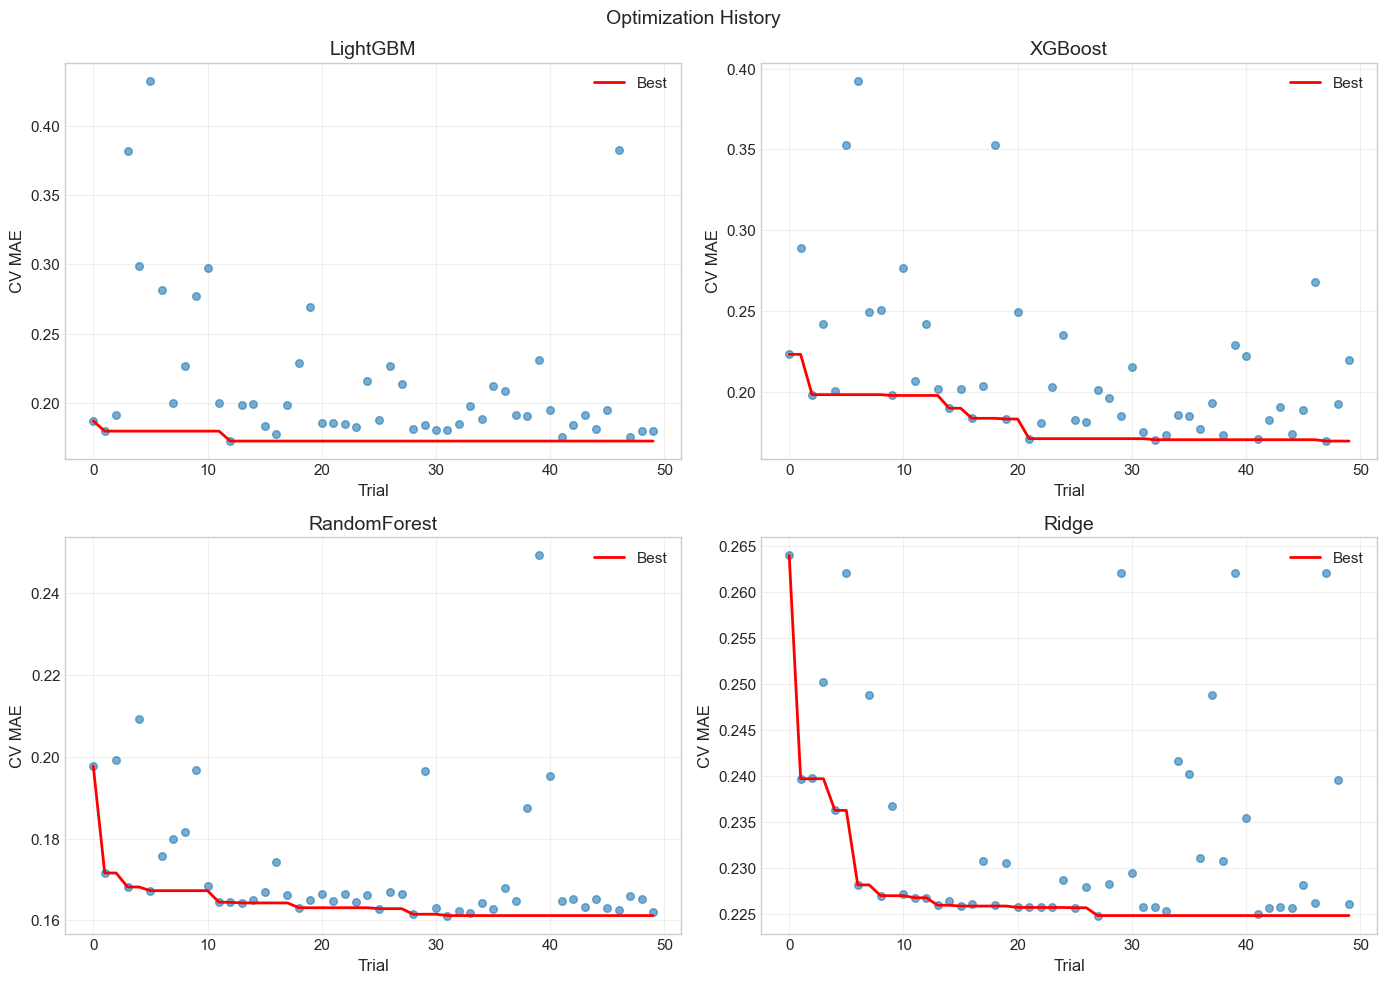

In [384]:
# Optimization history
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for idx, (model_name, study) in enumerate(auto_mlf.results_.items()):
    if idx >= 4:
        break
    ax = axes[idx]
    
    trial_values = [t.value for t in study.trials]
    ax.scatter(range(len(trial_values)), trial_values, alpha=0.6, s=30)
    
    # Best so far line
    best_so_far = [min(trial_values[:i+1]) for i in range(len(trial_values))]
    ax.plot(range(len(best_so_far)), best_so_far, 'r-', linewidth=2, label='Best')
    
    ax.set_xlabel('Trial')
    ax.set_ylabel('CV MAE')
    ax.set_title(f'{model_name}')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle('Optimization History', fontsize=14)
plt.tight_layout()
plt.show()

Checking for each unique series_id (CV is performed)

In [385]:
print("=" * 70)
print("GENERATING ML MODEL RECOMMENDATIONS PER SERIES")
print("=" * 70)
print("\nUsing cross-validation for fair out-of-sample evaluation")
print("(Hyperparameters are fixed from optimization - only evaluating per series)")

model_names = list(auto_mlf.models_.keys())
print(f"\nModels: {model_names}")
print(f"CV Windows: {config.n_windows}")
print(f"Horizon: {config.horizon}")

# Run cross-validation for each fitted model
# This uses the ALREADY OPTIMIZED hyperparameters (no re-tuning)
cv_results = {}

for model_name, mlf in auto_mlf.models_.items():
    print(f"  Running CV for {model_name}...", end=" ")
    
    cv_df = mlf.cross_validation(
        df=train_df,
        static_features=[],
        h=config.horizon,
        n_windows=config.n_windows,
        step_size=config.step_size,
    )
    cv_results[model_name] = cv_df
    print(f"✓ ({len(cv_df)} predictions)")

# Merge all CV results into one DataFrame
merged_cv = cv_results[model_names[0]][['unique_id', 'ds', 'y', 'cutoff']].copy()
for model_name in model_names:
    merged_cv[model_name] = cv_results[model_name][model_name]

print(f"\nTotal CV predictions: {len(merged_cv)}")

# Evaluate using MAE and SMAPE
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import mae, smape

eval_df = evaluate(merged_cv, metrics=[mae, smape], models=model_names)

# Build recommendations per series
recommendations = []

for uid in train_df['unique_id'].unique():
    uid_eval = eval_df[eval_df['unique_id'] == uid]
    
    if len(uid_eval) == 0:
        continue
    
    # Get MAE scores for this series
    mae_row = uid_eval[uid_eval['metric'] == 'mae'].iloc[0]
    mae_scores = {m: mae_row[m] for m in model_names}
    best_mae_model = min(mae_scores, key=mae_scores.get)
    
    # Get SMAPE scores for this series
    smape_row = uid_eval[uid_eval['metric'] == 'smape'].iloc[0]
    smape_scores = {m: smape_row[m] for m in model_names}
    best_smape_model = min(smape_scores, key=smape_scores.get)
    
    # Get model parameters (from optimization results)
    best_config = auto_mlf.results_[best_mae_model].best_trial.user_attrs['config']
    lags = best_config.get('mlf_init_params', {}).get('lags', 'default')
    params = best_config.get('model_params', {})
    
    # Calculate confidence based on margin between best and 2nd best
    sorted_mae = sorted(mae_scores.values())
    if len(sorted_mae) > 1 and sorted_mae[0] > 0:
        margin = (sorted_mae[1] - sorted_mae[0]) / sorted_mae[0]
        confidence = 'High' if margin >= 0.15 else 'Medium' if margin >= 0.05 else 'Low'
    else:
        confidence = 'Low'
    
    # Format key parameters for display
    key_params = {k: round(v, 4) if isinstance(v, float) else v 
                  for k, v in params.items() 
                  if k in ['n_estimators', 'max_depth', 'learning_rate', 
                           'reg_alpha', 'reg_lambda', 'alpha', 'num_leaves',
                           'min_samples_leaf', 'min_samples_split']}
    
    recommendations.append({
        'unique_id': uid,
        'recommended_model': best_mae_model,
        'confidence': confidence,
        'cv_mae': mae_scores[best_mae_model],
        'cv_smape': smape_scores[best_smape_model],
        'best_model_smape': best_smape_model,
        'models_agree': best_mae_model == best_smape_model,
        'lags': str(lags),
        'model_params': str(key_params),
        # All model scores for comparison
        **{f'{m}_mae': mae_scores[m] for m in model_names},
        **{f'{m}_smape': smape_scores[m] for m in model_names},
    })

ml_recommendations_df = pd.DataFrame(recommendations)

# =============================================================================
# Summary
# =============================================================================
print("\n" + "=" * 70)
print("RECOMMENDATIONS SUMMARY")
print("=" * 70)

print("\n📊 Best Model Distribution (by MAE):")
print(ml_recommendations_df['recommended_model'].value_counts().to_string())

print("\n📊 Best Model Distribution (by SMAPE):")
print(ml_recommendations_df['best_model_smape'].value_counts().to_string())

print("\n📊 Confidence Distribution:")
print(ml_recommendations_df['confidence'].value_counts().to_string())

agree_count = ml_recommendations_df['models_agree'].sum()
total = len(ml_recommendations_df)
print(f"\n📊 MAE vs SMAPE Agreement: {agree_count}/{total} ({agree_count/total*100:.1f}%)")

print("\n📊 Average CV Scores by Model:")
for model in model_names:
    avg_mae = ml_recommendations_df[f'{model}_mae'].mean()
    avg_smape = ml_recommendations_df[f'{model}_smape'].mean()
    print(f"   {model:15s}: MAE={avg_mae:>12,.0f}  SMAPE={avg_smape:.4f} ({avg_smape*100:.2f}%)")

print(f"\n✓ Generated recommendations for {len(ml_recommendations_df)} series")

GENERATING ML MODEL RECOMMENDATIONS PER SERIES

Using cross-validation for fair out-of-sample evaluation
(Hyperparameters are fixed from optimization - only evaluating per series)

Models: ['LightGBM', 'XGBoost', 'RandomForest', 'Ridge']
CV Windows: 2
Horizon: 8
  Running CV for LightGBM... ✓ (1248 predictions)
  Running CV for XGBoost... ✓ (1248 predictions)
  Running CV for RandomForest... ✓ (1248 predictions)
  Running CV for Ridge... ✓ (1248 predictions)

Total CV predictions: 1248

RECOMMENDATIONS SUMMARY

📊 Best Model Distribution (by MAE):
recommended_model
LightGBM        24
RandomForest    23
Ridge           22
XGBoost          9

📊 Best Model Distribution (by SMAPE):
best_model_smape
RandomForest    25
Ridge           24
LightGBM        22
XGBoost          7

📊 Confidence Distribution:
confidence
High      44
Low       20
Medium    14

📊 MAE vs SMAPE Agreement: 74/78 (94.9%)

📊 Average CV Scores by Model:
   LightGBM       : MAE=      20,325  SMAPE=0.1693 (16.93%)
   XGBoost 

In [386]:
save_path = OUTPUT_PATH
excel_path = os.path.join(save_path, 'ML_Recommendations.xlsx')

with pd.ExcelWriter(excel_path, engine='openpyxl') as writer:
    # Sheet 1: Recommendations
    ml_recommendations_df.to_excel(writer, sheet_name='Recommendations', index=False)
    
    # Sheet 2: Model Parameters
    params_data = []
    for model_name, study in auto_mlf.results_.items():
        best_config = study.best_trial.user_attrs['config']
        model_params = best_config.get('model_params', {})
        init_params = best_config.get('mlf_init_params', {})
        
        row = {'Model': model_name, 'CV_Score': study.best_value, 
               'Lags': str(init_params.get('lags', 'default'))}
        row.update({k: round(v, 6) if isinstance(v, float) else v 
                    for k, v in model_params.items()})
        params_data.append(row)
    
    pd.DataFrame(params_data).to_excel(writer, sheet_name='Model_Parameters', index=False)
    
    # Sheet 3: Full CV Evaluation (per series, per metric)
    eval_df.to_excel(writer, sheet_name='CV_Evaluation', index=False)

print(f"\n✓ Exported to: {excel_path}")


✓ Exported to: C:\Users\Lilian\OneDrive - purdue.edu\VS code\Data\ATC\Forecast\ML\\ML_Recommendations.xlsx


## Section 5: Generating Forecasts

In [387]:
print("=" * 60); print("SECTION 5: GENERATE FORECASTS"); print("=" * 60)

print("\nFitted Models:")
for model_name in auto_mlf.models_.keys():
    print(f"  - {model_name}")

SECTION 5: GENERATE FORECASTS

Fitted Models:
  - LightGBM
  - XGBoost
  - RandomForest
  - Ridge


In [388]:
# Generate forecasts
print("\nGenerating forecasts (Point Scenario)...")

print("\n⚠️  Refitting models after cross-validation...")

for model_name, mlf in auto_mlf.models_.items():
    print(f"  Refitting {model_name}...", end=" ")
    mlf.fit(
        df=train_df,
        id_col='unique_id',
        time_col='ds',
        target_col='y',
        static_features=[],
    )
    print("✓")

print("\n✅ All models refitted! Ready to generate forecasts.\n")

forecasts_point = auto_mlf.predict(h=config.horizon, X_df=X_future_point)

print(f"  Shape: {forecasts_point.shape}")
print(f"  Models: {[c for c in forecasts_point.columns if c not in ['unique_id', 'ds']]}")

forecasts_point.head(15)


Generating forecasts (Point Scenario)...

⚠️  Refitting models after cross-validation...
  Refitting LightGBM... ✓
  Refitting XGBoost... ✓
  Refitting RandomForest... ✓
  Refitting Ridge... ✓

✅ All models refitted! Ready to generate forecasts.

  Shape: (624, 6)
  Models: ['LightGBM', 'XGBoost', 'RandomForest', 'Ridge']


,unique_id,ds,LightGBM,XGBoost,RandomForest,Ridge
0,MI_A01,2025-01-01,37474.700046,39272.042969,53591.677508,61259.413005
1,MI_A01,2025-04-01,41656.869329,43793.257812,53747.231074,70775.863889
2,MI_A01,2025-07-01,47482.573723,46837.277344,52143.413790,74370.066767
3,MI_A01,2025-10-01,51158.801069,47487.656250,52151.585473,78507.941098
4,MI_A01,2026-01-01,57083.610925,65144.070312,58424.542580,80201.270498
5,MI_A01,2026-04-01,47991.742463,73368.773438,56976.165740,81150.903837
6,MI_A01,2026-07-01,50691.893479,77371.093750,55216.498640,81878.001022
7,MI_A01,2026-10-01,57992.033553,80729.289062,54219.135284,82484.138930
8,MI_A02,2025-01-01,227165.146605,240279.468750,251653.216901,264193.353954
9,MI_A02,2025-04-01,212763.063088,247577.843750,259192.430914,263625.496539


In [389]:
# Low/High scenarios
forecasts_low = None
forecasts_high = None

if X_future_low is not None:
    print("\nGenerating forecasts (Low Scenario)...")
    forecasts_low = auto_mlf.predict(h=config.horizon, X_df=X_future_low)
    print(f"  Shape: {forecasts_low.shape}")

if X_future_high is not None:
    print("\nGenerating forecasts (High Scenario)...")
    forecasts_high = auto_mlf.predict(h=config.horizon, X_df=X_future_high)
    print(f"  Shape: {forecasts_high.shape}")


Generating forecasts (Low Scenario)...
  Shape: (624, 6)

Generating forecasts (High Scenario)...
  Shape: (624, 6)


In [390]:
# Create ensemble
print("\nCreating Ensemble (weighted by inverse MAE)...")

model_cols = [c for c in forecasts_point.columns if c not in ['unique_id', 'ds']]

weights = {}
for model_name in model_cols:
    if model_name in auto_mlf.results_:
        weights[model_name] = 1.0 / auto_mlf.results_[model_name].best_value

total = sum(weights.values())
weights = {k: v/total for k, v in weights.items()}

print("  Weights:")
for m, w in sorted(weights.items(), key=lambda x: -x[1]):
    print(f"    {m}: {w:.2%}")

forecasts_point['Ensemble'] = sum(forecasts_point[m] * w for m, w in weights.items())
print("\n  Ensemble added!")


Creating Ensemble (weighted by inverse MAE)...
  Weights:
    RandomForest: 27.75%
    XGBoost: 26.42%
    LightGBM: 25.98%
    Ridge: 19.86%

  Ensemble added!


## Section 6: Visualization & Evaluation

In [258]:
# Set style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Color palette for models
MODEL_COLORS = {
    'LightGBM': '#2E86AB',       # Blue
    'XGBoost': '#E94F37',        # Red
    'RandomForest': '#28A745',   # Green
    'Ridge': '#9B59B6',          # Purple     
}

# Prepare evaluation data for visualization
mae_pivot = eval_df[eval_df['metric'] == 'mae'].drop(columns=['metric']).set_index('unique_id')
smape_pivot = eval_df[eval_df['metric'] == 'smape'].drop(columns=['metric']).set_index('unique_id')

print(f"\n✓ Prepared evaluation data for {len(mae_pivot)} series")
print(f"✓ Models: {model_names}")


✓ Prepared evaluation data for 156 series
✓ Models: ['LightGBM', 'XGBoost', 'RandomForest', 'Ridge']


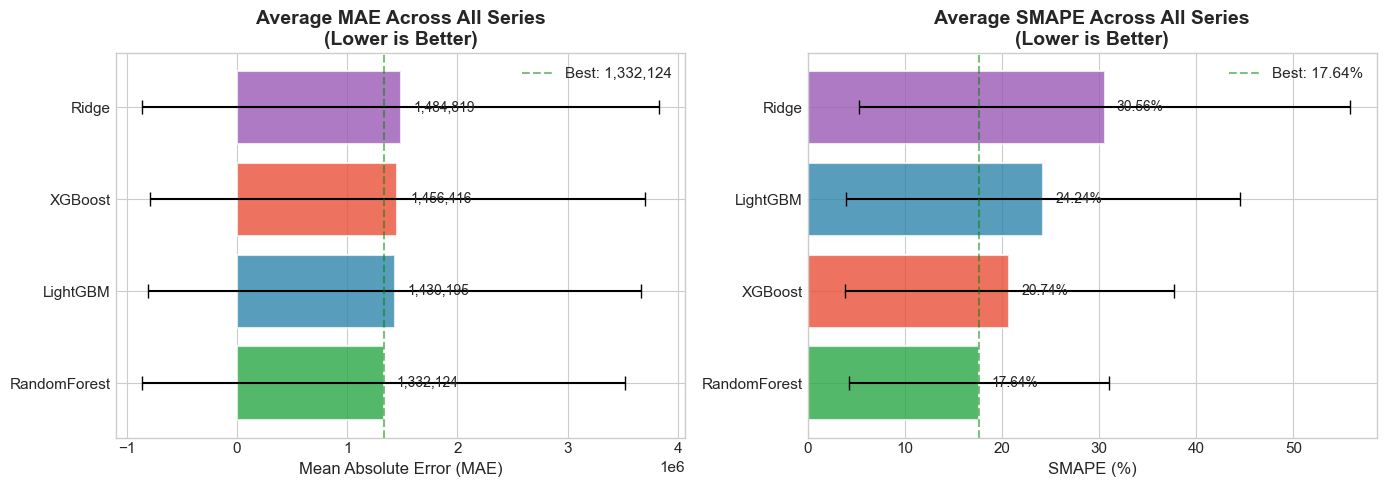


✓ Saved: ml_model_performance_overview.png


In [259]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- MAE Comparison ---
ax1 = axes[0]
mae_means = mae_pivot[model_names].mean().sort_values()
mae_stds = mae_pivot[model_names].std()[mae_means.index]

colors = [MODEL_COLORS.get(m, '#666666') for m in mae_means.index]
bars1 = ax1.barh(mae_means.index, mae_means.values, xerr=mae_stds.values, 
                  color=colors, capsize=5, alpha=0.8, edgecolor='white', linewidth=1.5)
ax1.set_xlabel('Mean Absolute Error (MAE)')
ax1.set_title('Average MAE Across All Series\n(Lower is Better)', fontweight='bold')
ax1.axvline(x=mae_means.min(), color='green', linestyle='--', alpha=0.5, label=f'Best: {mae_means.min():,.0f}')

for bar, val in zip(bars1, mae_means.values):
    ax1.text(val + mae_stds.max()*0.05, bar.get_y() + bar.get_height()/2, 
             f'{val:,.0f}', va='center', fontsize=10)
ax1.legend()

# --- SMAPE Comparison ---
ax2 = axes[1]
smape_means = smape_pivot[model_names].mean().sort_values()
smape_stds = smape_pivot[model_names].std()[smape_means.index]

colors = [MODEL_COLORS.get(m, '#666666') for m in smape_means.index]
bars2 = ax2.barh(smape_means.index, smape_means.values * 100, xerr=smape_stds.values * 100,
                  color=colors, capsize=5, alpha=0.8, edgecolor='white', linewidth=1.5)
ax2.set_xlabel('SMAPE (%)')
ax2.set_title('Average SMAPE Across All Series\n(Lower is Better)', fontweight='bold')
ax2.axvline(x=smape_means.min()*100, color='green', linestyle='--', alpha=0.5, label=f'Best: {smape_means.min()*100:.2f}%')

for bar, val in zip(bars2, smape_means.values):
    ax2.text(val*100 + smape_stds.max()*100*0.05, bar.get_y() + bar.get_height()/2, 
             f'{val*100:.2f}%', va='center', fontsize=10)
ax2.legend()

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_PATH, 'ml_model_performance_overview.png'), dpi=150, bbox_inches='tight')
plt.show()
print("\n✓ Saved: ml_model_performance_overview.png")

In [260]:
print("\n" + "=" * 80)
print("MODEL PERFORMANCE STATISTICS ACROSS SERIES")
print("=" * 80)

stats_data = []
for model in model_names:
    mae_vals = mae_pivot[model]
    smape_vals = smape_pivot[model] * 100
    
    stats_data.append({
        'Model': model,
        'MAE_Mean': mae_vals.mean(),
        'MAE_Median': mae_vals.median(),
        'MAE_Std': mae_vals.std(),
        'MAE_Min': mae_vals.min(),
        'MAE_Max': mae_vals.max(),
        'SMAPE_Mean': smape_vals.mean(),
        'SMAPE_Median': smape_vals.median(),
        'SMAPE_Std': smape_vals.std(),
        'SMAPE_Min': smape_vals.min(),
        'SMAPE_Max': smape_vals.max(),
    })

model_stats_df = pd.DataFrame(stats_data)

print("\n📊 MAE Statistics:")
print("-" * 80)
print(f"{'Model':<15} {'Mean':>12} {'Median':>12} {'Std':>12} {'Min':>12} {'Max':>12}")
print("-" * 80)
for _, row in model_stats_df.sort_values('MAE_Mean').iterrows():
    print(f"{row['Model']:<15} {row['MAE_Mean']:>12,.0f} {row['MAE_Median']:>12,.0f} "
          f"{row['MAE_Std']:>12,.0f} {row['MAE_Min']:>12,.0f} {row['MAE_Max']:>12,.0f}")

print("\n📊 SMAPE Statistics (%):")
print("-" * 80)
print(f"{'Model':<15} {'Mean':>12} {'Median':>12} {'Std':>12} {'Min':>12} {'Max':>12}")
print("-" * 80)
for _, row in model_stats_df.sort_values('SMAPE_Mean').iterrows():
    print(f"{row['Model']:<15} {row['SMAPE_Mean']:>12.2f}% {row['SMAPE_Median']:>12.2f}% "
          f"{row['SMAPE_Std']:>12.2f}% {row['SMAPE_Min']:>12.2f}% {row['SMAPE_Max']:>12.2f}%")

model_stats_df.to_csv(os.path.join(OUTPUT_PATH, 'ml_model_statistics.csv'), index=False)
print("\n✓ Saved: ml_model_statistics.csv")


MODEL PERFORMANCE STATISTICS ACROSS SERIES

📊 MAE Statistics:
--------------------------------------------------------------------------------
Model                   Mean       Median          Std          Min          Max
--------------------------------------------------------------------------------
RandomForest       1,332,124      531,655    2,192,060          300   13,030,292
LightGBM           1,430,195      568,900    2,236,844       45,023   13,253,118
XGBoost            1,456,416      605,319    2,247,828       12,044   13,338,223
Ridge              1,484,819      673,902    2,347,368      258,051   17,028,242

📊 SMAPE Statistics (%):
--------------------------------------------------------------------------------
Model                   Mean       Median          Std          Min          Max
--------------------------------------------------------------------------------
RandomForest           17.64%        14.13%        13.42%         1.75%        66.68%
XGBoost         

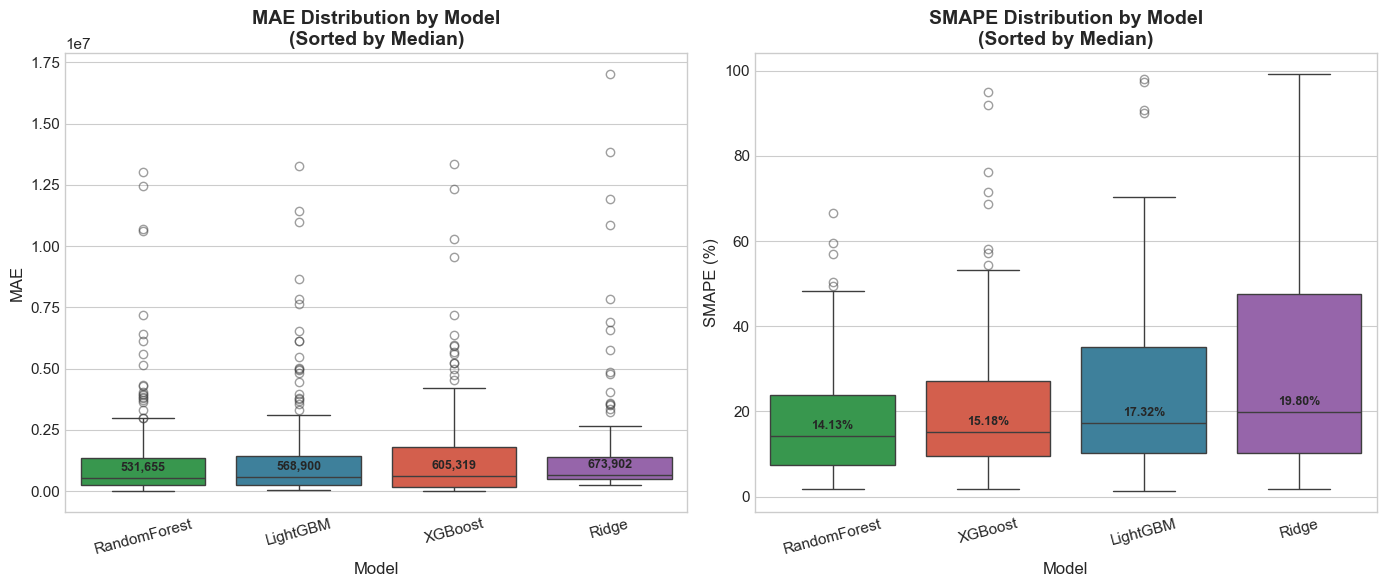


✓ Saved: ml_error_distribution_boxplot.png


In [261]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

mae_melt = mae_pivot[model_names].melt(var_name='Model', value_name='MAE')
smape_melt = smape_pivot[model_names].melt(var_name='Model', value_name='SMAPE')
smape_melt['SMAPE'] = smape_melt['SMAPE'] * 100

model_order_mae = mae_pivot[model_names].median().sort_values().index.tolist()
model_order_smape = (smape_pivot[model_names] * 100).median().sort_values().index.tolist()

# MAE Box Plot
ax1 = axes[0]
palette_mae = [MODEL_COLORS.get(m, '#666666') for m in model_order_mae]
sns.boxplot(data=mae_melt, x='Model', y='MAE', order=model_order_mae, 
            palette=palette_mae, ax=ax1, showfliers=True, flierprops={'alpha': 0.5})
ax1.set_title('MAE Distribution by Model\n(Sorted by Median)', fontweight='bold')
ax1.set_ylabel('MAE')
ax1.tick_params(axis='x', rotation=15)

medians_mae = mae_pivot[model_order_mae].median()
for i, (model, median) in enumerate(medians_mae.items()):
    ax1.annotate(f'{median:,.0f}', xy=(i, median), xytext=(0, 5),
                 textcoords='offset points', ha='center', fontsize=9, fontweight='bold')

# SMAPE Box Plot
ax2 = axes[1]
palette_smape = [MODEL_COLORS.get(m, '#666666') for m in model_order_smape]
sns.boxplot(data=smape_melt, x='Model', y='SMAPE', order=model_order_smape,
            palette=palette_smape, ax=ax2, showfliers=True, flierprops={'alpha': 0.5})
ax2.set_title('SMAPE Distribution by Model\n(Sorted by Median)', fontweight='bold')
ax2.set_ylabel('SMAPE (%)')
ax2.tick_params(axis='x', rotation=15)

medians_smape = (smape_pivot[model_order_smape] * 100).median()
for i, (model, median) in enumerate(medians_smape.items()):
    ax2.annotate(f'{median:.2f}%', xy=(i, median), xytext=(0, 5),
                 textcoords='offset points', ha='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_PATH, 'ml_error_distribution_boxplot.png'), dpi=150, bbox_inches='tight')
plt.show()
print("\n✓ Saved: ml_error_distribution_boxplot.png")

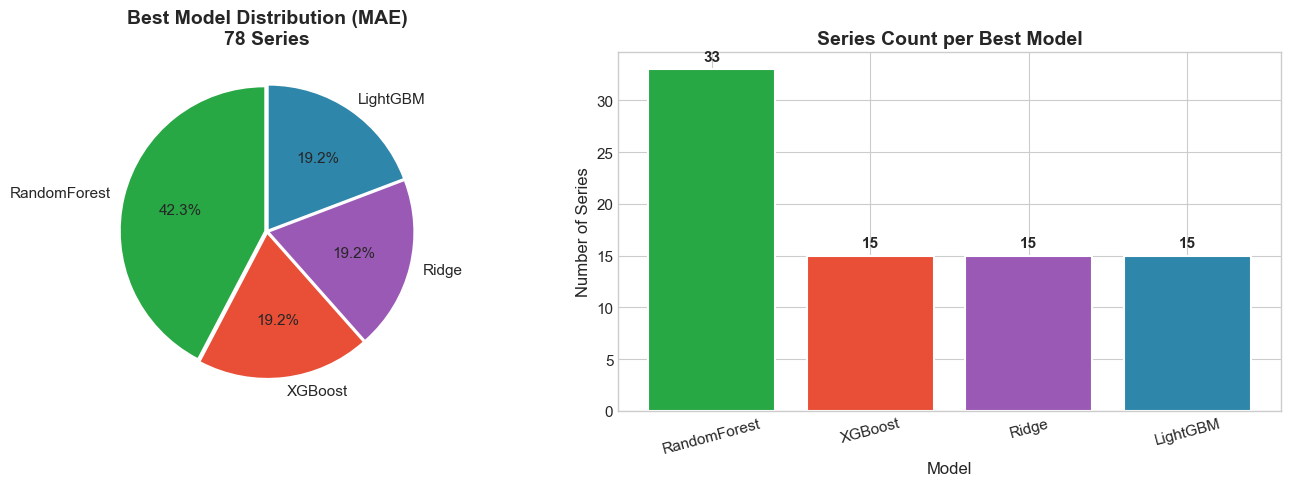


📊 Best Model Distribution:
----------------------------------------
   RandomForest   :  33 series ( 42.3%)
   XGBoost        :  15 series ( 19.2%)
   Ridge          :  15 series ( 19.2%)
   LightGBM       :  15 series ( 19.2%)

✓ Saved: ml_best_model_distribution.png


In [262]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

best_model_counts = ml_recommendations_df['recommended_model'].value_counts()
colors_pie = [MODEL_COLORS.get(m, '#666666') for m in best_model_counts.index]

# Pie chart
ax1 = axes[0]
wedges, texts, autotexts = ax1.pie(
    best_model_counts.values, 
    labels=best_model_counts.index,
    autopct='%1.1f%%',
    colors=colors_pie,
    explode=[0.02] * len(best_model_counts),
    startangle=90,
    textprops={'fontsize': 11}
)
ax1.set_title(f'Best Model Distribution (MAE)\n{len(ml_recommendations_df)} Series', fontweight='bold')

# Bar chart
ax2 = axes[1]
bars = ax2.bar(best_model_counts.index, best_model_counts.values, color=colors_pie, 
               edgecolor='white', linewidth=1.5)
ax2.set_ylabel('Number of Series')
ax2.set_xlabel('Model')
ax2.set_title('Series Count per Best Model', fontweight='bold')
ax2.tick_params(axis='x', rotation=15)

for bar, count in zip(bars, best_model_counts.values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             str(count), ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_PATH, 'ml_best_model_distribution.png'), dpi=150, bbox_inches='tight')
plt.show()

print("\n📊 Best Model Distribution:")
print("-" * 40)
for model, count in best_model_counts.items():
    pct = count / len(ml_recommendations_df) * 100
    print(f"   {model:<15}: {count:>3} series ({pct:>5.1f}%)")
print("\n✓ Saved: ml_best_model_distribution.png")

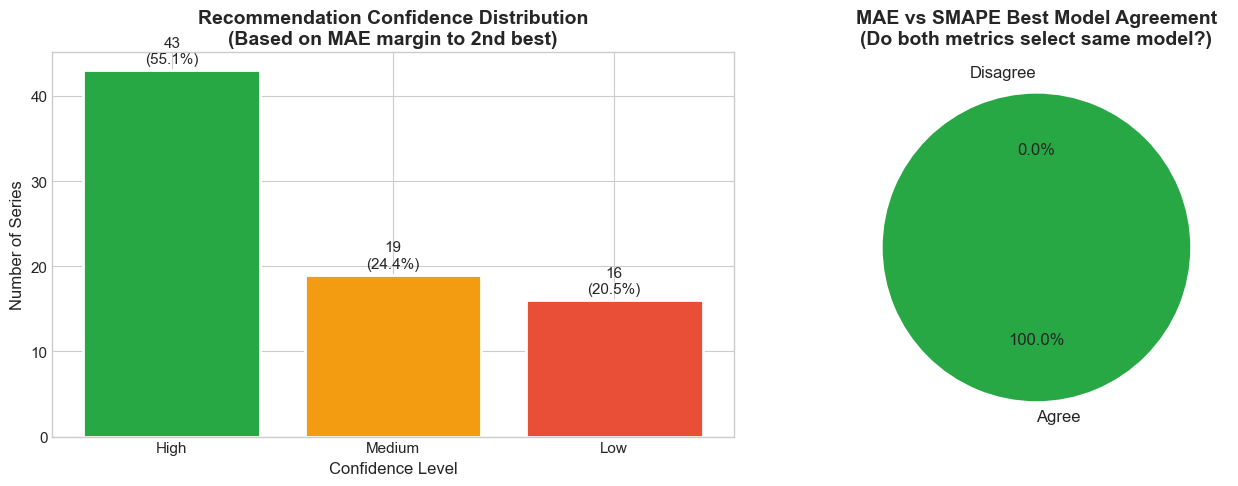


✓ Saved: ml_confidence_analysis.png


In [263]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confidence distribution
ax1 = axes[0]
confidence_counts = ml_recommendations_df['confidence'].value_counts()
confidence_order = ['High', 'Medium', 'Low']
confidence_colors = {'High': '#28A745', 'Medium': '#F39C12', 'Low': '#E94F37'}

confidence_counts = confidence_counts.reindex(confidence_order).dropna()
colors_conf = [confidence_colors[c] for c in confidence_counts.index]

bars = ax1.bar(confidence_counts.index, confidence_counts.values, color=colors_conf,
               edgecolor='white', linewidth=2)
ax1.set_ylabel('Number of Series')
ax1.set_xlabel('Confidence Level')
ax1.set_title('Recommendation Confidence Distribution\n(Based on MAE margin to 2nd best)', fontweight='bold')

for bar, count in zip(bars, confidence_counts.values):
    pct = count / len(ml_recommendations_df) * 100
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{count}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=11)

# MAE vs SMAPE Agreement
ax2 = axes[1]
agreement = ml_recommendations_df['models_agree'].value_counts()
agreement_labels = ['Agree', 'Disagree']
agreement_values = [agreement.get(True, 0), agreement.get(False, 0)]
agreement_colors = ['#28A745', '#E94F37']

ax2.pie(agreement_values, labels=agreement_labels, autopct='%1.1f%%',
        colors=agreement_colors, explode=[0.02, 0.02], startangle=90,
        textprops={'fontsize': 12})
ax2.set_title('MAE vs SMAPE Best Model Agreement\n(Do both metrics select same model?)', fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_PATH, 'ml_confidence_analysis.png'), dpi=150, bbox_inches='tight')
plt.show()
print("\n✓ Saved: ml_confidence_analysis.png")


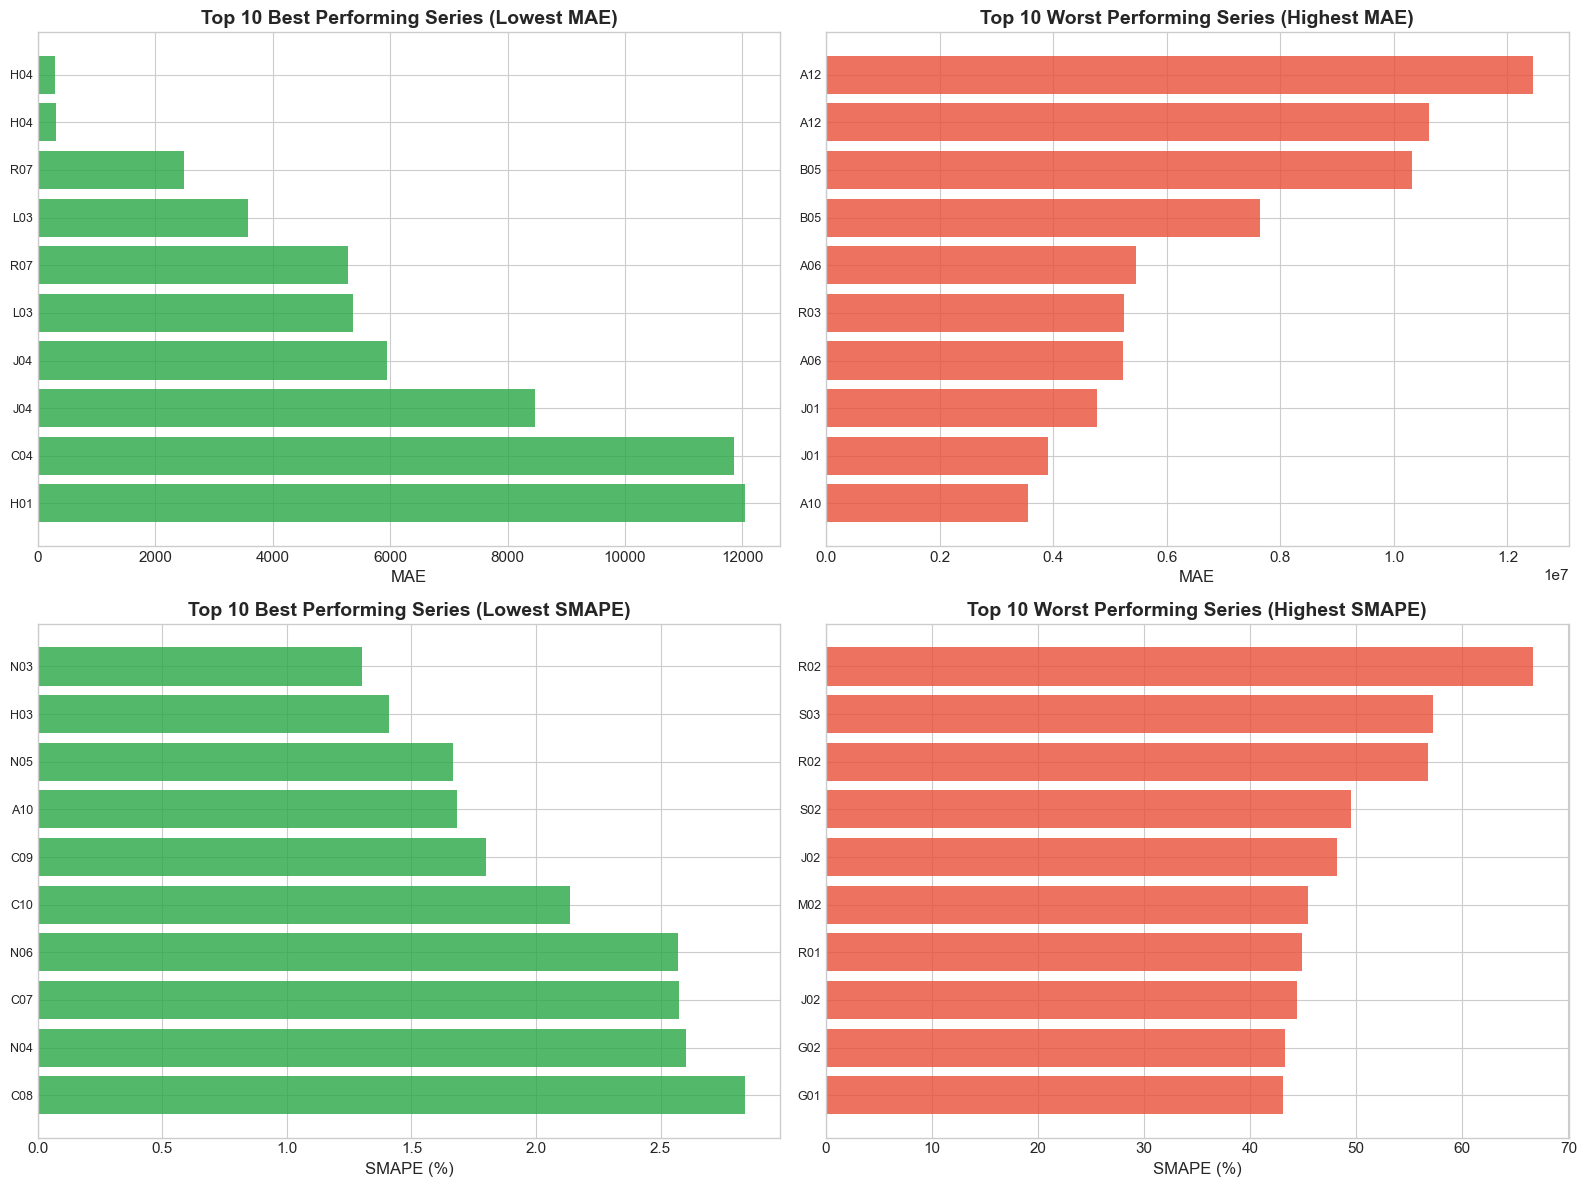


✓ Saved: ml_best_worst_series.png


In [264]:
best_mae_per_series = mae_pivot[model_names].min(axis=1).sort_values()
best_smape_per_series = smape_pivot[model_names].min(axis=1).sort_values()

top_n = 10

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Top performers (lowest MAE)
ax1 = axes[0, 0]
top_mae = best_mae_per_series.head(top_n)
ax1.barh(range(len(top_mae)), top_mae.values, color='#28A745', alpha=0.8)
ax1.set_yticks(range(len(top_mae)))
ax1.set_yticklabels([uid.split('_')[-1][:20] for uid in top_mae.index], fontsize=9)
ax1.set_xlabel('MAE')
ax1.set_title(f'Top {top_n} Best Performing Series (Lowest MAE)', fontweight='bold')
ax1.invert_yaxis()

# Bottom performers (highest MAE)
ax2 = axes[0, 1]
bottom_mae = best_mae_per_series.tail(top_n).sort_values(ascending=False)
ax2.barh(range(len(bottom_mae)), bottom_mae.values, color='#E94F37', alpha=0.8)
ax2.set_yticks(range(len(bottom_mae)))
ax2.set_yticklabels([uid.split('_')[-1][:20] for uid in bottom_mae.index], fontsize=9)
ax2.set_xlabel('MAE')
ax2.set_title(f'Top {top_n} Worst Performing Series (Highest MAE)', fontweight='bold')
ax2.invert_yaxis()

# Top performers (lowest SMAPE)
ax3 = axes[1, 0]
top_smape = best_smape_per_series.head(top_n) * 100
ax3.barh(range(len(top_smape)), top_smape.values, color='#28A745', alpha=0.8)
ax3.set_yticks(range(len(top_smape)))
ax3.set_yticklabels([uid.split('_')[-1][:20] for uid in top_smape.index], fontsize=9)
ax3.set_xlabel('SMAPE (%)')
ax3.set_title(f'Top {top_n} Best Performing Series (Lowest SMAPE)', fontweight='bold')
ax3.invert_yaxis()

# Bottom performers (highest SMAPE)
ax4 = axes[1, 1]
bottom_smape = best_smape_per_series.tail(top_n).sort_values(ascending=False) * 100
ax4.barh(range(len(bottom_smape)), bottom_smape.values, color='#E94F37', alpha=0.8)
ax4.set_yticks(range(len(bottom_smape)))
ax4.set_yticklabels([uid.split('_')[-1][:20] for uid in bottom_smape.index], fontsize=9)
ax4.set_xlabel('SMAPE (%)')
ax4.set_title(f'Top {top_n} Worst Performing Series (Highest SMAPE)', fontweight='bold')
ax4.invert_yaxis()

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_PATH, 'ml_best_worst_series.png'), dpi=150, bbox_inches='tight')
plt.show()
print("\n✓ Saved: ml_best_worst_series.png")

In [265]:
print("\n" + "=" * 80)
print("📈 ML FORECASTING MODEL EVALUATION SUMMARY")
print("=" * 80)

# Best overall model
best_overall = model_stats_df.loc[model_stats_df['MAE_Mean'].idxmin()]
print(f"\n🏆 Best Overall Model (by Mean MAE): {best_overall['Model']}")
print(f"   Mean MAE: {best_overall['MAE_Mean']:,.0f}")
print(f"   Mean SMAPE: {best_overall['SMAPE_Mean']:.2f}%")

# Most consistent model
most_consistent = model_stats_df.loc[model_stats_df['MAE_Std'].idxmin()]
print(f"\n📊 Most Consistent Model (lowest MAE std): {most_consistent['Model']}")
print(f"   MAE Std: {most_consistent['MAE_Std']:,.0f}")

# Best model distribution
print(f"\n📊 Best Model per Series:")
for model, count in ml_recommendations_df['recommended_model'].value_counts().items():
    pct = count / len(ml_recommendations_df) * 100
    print(f"   {model}: {count} series ({pct:.1f}%)")

# Confidence summary
print(f"\n📊 Recommendation Confidence:")
for conf, count in ml_recommendations_df['confidence'].value_counts().items():
    pct = count / len(ml_recommendations_df) * 100
    print(f"   {conf}: {count} series ({pct:.1f}%)")

# Agreement
agree_pct = ml_recommendations_df['models_agree'].mean() * 100
print(f"\n📊 MAE vs SMAPE Agreement: {agree_pct:.1f}%")

print("\n" + "=" * 80)
print("✅ Section 6 Complete - All visualizations saved!")
print("=" * 80)


📈 ML FORECASTING MODEL EVALUATION SUMMARY

🏆 Best Overall Model (by Mean MAE): RandomForest
   Mean MAE: 1,332,124
   Mean SMAPE: 17.64%

📊 Most Consistent Model (lowest MAE std): RandomForest
   MAE Std: 2,192,060

📊 Best Model per Series:
   RandomForest: 33 series (42.3%)
   XGBoost: 15 series (19.2%)
   Ridge: 15 series (19.2%)
   LightGBM: 15 series (19.2%)

📊 Recommendation Confidence:
   High: 43 series (55.1%)
   Medium: 19 series (24.4%)
   Low: 16 series (20.5%)

📊 MAE vs SMAPE Agreement: 100.0%

✅ Section 6 Complete - All visualizations saved!


## Section 7: Save Results

In [391]:
print("=" * 60)
print("SECTION 7: SAVE RESULTS")
print("=" * 60)

os.makedirs(OUTPUT_PATH, exist_ok=True)

# Forecasts
forecasts_point.to_csv(os.path.join(OUTPUT_PATH, f'{TARGET}_forecasts_point.csv'), index=False)
print(f"Saved: {TARGET}_forecasts_point.csv")

if forecasts_low is not None:
    forecasts_low.to_csv(os.path.join(OUTPUT_PATH, f'{TARGET}_forecasts_low.csv'), index=False)
    print(f"Saved: {TARGET}_forecasts_low.csv")

if forecasts_high is not None:
    forecasts_high.to_csv(os.path.join(OUTPUT_PATH, f'{TARGET}_forecasts_high.csv'), index=False)
    print(f"Saved: {TARGET}_forecasts_high.csv")

# Model comparison
results_df.to_csv(os.path.join(OUTPUT_PATH, f'{TARGET}_model_comparison.csv'), index=False)
print(f"Saved: {TARGET}_model_comparison.csv")

# Best configs
configs_to_save = {}
for model_name, cfg in best_configs.items():
    model_params = cfg.get('model_params', {})
    init_params = cfg.get('mlf_init_params', {})
    configs_to_save[model_name] = {
        'model_params': {k: v for k, v in model_params.items() 
                        if k not in ['verbosity', 'random_state', 'n_jobs']},
        'lags': init_params.get('lags'),
        'cv_mae': auto_mlf.results_[model_name].best_value,
    }

with open(os.path.join(OUTPUT_PATH, f'{TARGET}_best_configs.json'), 'w') as f:
    json.dump(configs_to_save, f, indent=2, default=str)
print(f"Saved: {TARGET}_best_configs.json")

# Models
try:
    models_path = os.path.join(OUTPUT_PATH, 'models')
    auto_mlf.save(models_path)
    print(f"Saved: models/ directory")
except Exception as e:
    print(f"Note: Could not save models: {e}")

SECTION 7: SAVE RESULTS
Saved: y_1_forecasts_point.csv
Saved: y_1_forecasts_low.csv
Saved: y_1_forecasts_high.csv
Saved: y_1_model_comparison.csv
Saved: y_1_best_configs.json
Saved: models/ directory


In [392]:
print("\n" + "=" * 60)
print("PIPELINE COMPLETE")
print("=" * 60)

print(f"\nSummary:")
print(f"  Target: {TARGET_NAME}")
print(f"  States: {STATES if STATES else 'All'}")
print(f"  Series: {train_df['unique_id'].nunique()}")
print(f"  Trials per model: {NUM_SAMPLES}")
print(f"  Best Model: {best_model_name} (MAE: {best_model_score:,.2f})")
print(f"  Horizon: {config.horizon} quarters")
print(f"\nOutput: {OUTPUT_PATH}")


PIPELINE COMPLETE

Summary:
  Target: Number of Prescriptions
  States: ['MI']
  Series: 78
  Trials per model: 50
  Best Model: RandomForest (MAE: 0.16)
  Horizon: 8 quarters

Output: C:\Users\Lilian\OneDrive - purdue.edu\VS code\Data\ATC\Forecast\ML\\
